## Camera Calibration

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from math import *
import pickle
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

Image loaded


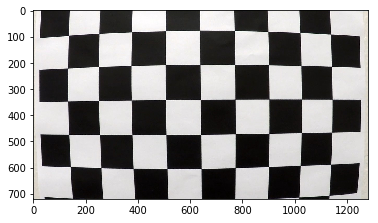

In [2]:
# Check if image will load
img = mpimg.imread('camera_cal/calibration1.jpg')
plt.imshow(img)
print('Image loaded')

In [3]:
def calibrate(images, nx, ny):
    objectpoints = []  # 3D 
    imgpoints = []  # 2D 

    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1, 2)

    fname = images[0]
    for fname in images:
        img = mpimg.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret:
            objectpoints.append(objp)
            imgpoints.append(corners)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objectpoints, imgpoints, gray.shape[::-1],None,None)
    
    return mtx, dist

def setup():
    images = glob.glob('camera_cal/calibration*.jpg')
    nx = 9
    ny = 6
    mtx, dist = calibrate(images, nx, ny)
    return mtx, dist


In [4]:
mtx, dist = setup()

## Distortion Correction

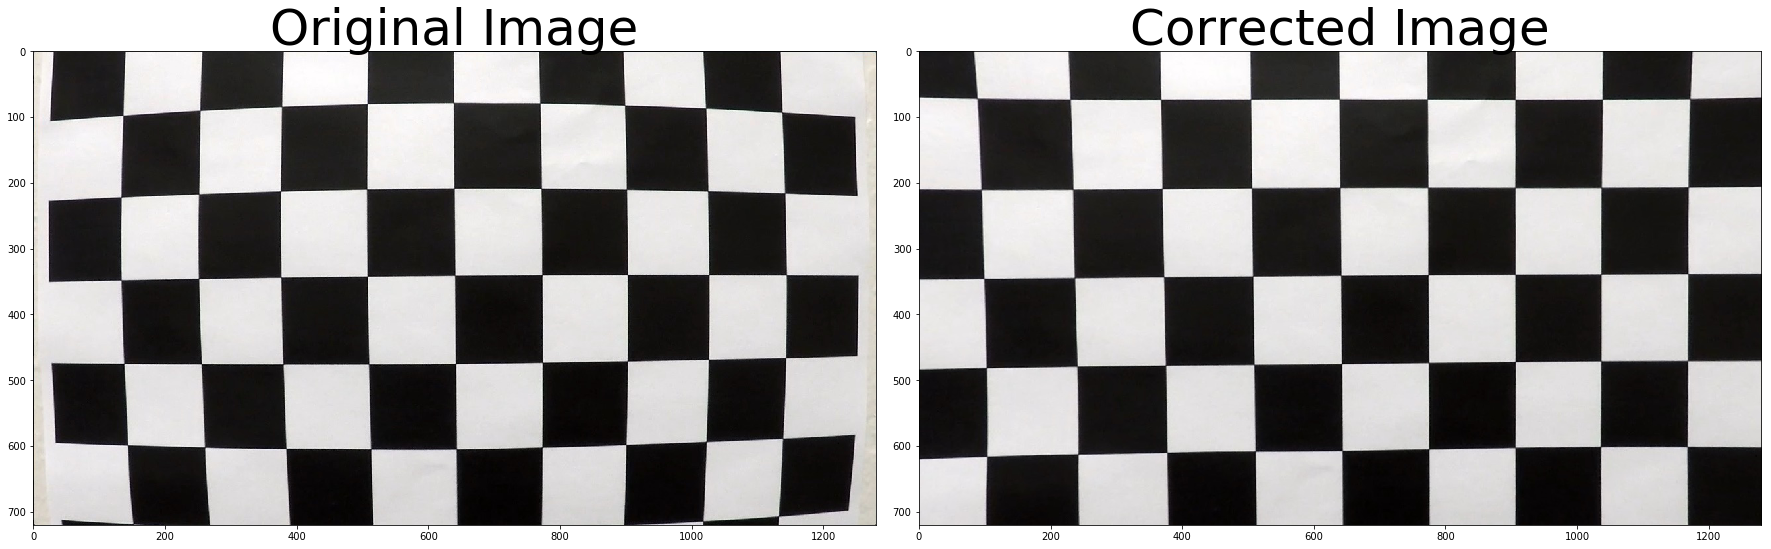

In [5]:
# Undistort chessboard
image = mpimg.imread('camera_cal/calibration1.jpg')

undist = cv2.undistort(image, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist)
ax2.set_title('Corrected Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.savefig('./output_images/undistort_calibration1.jpg')

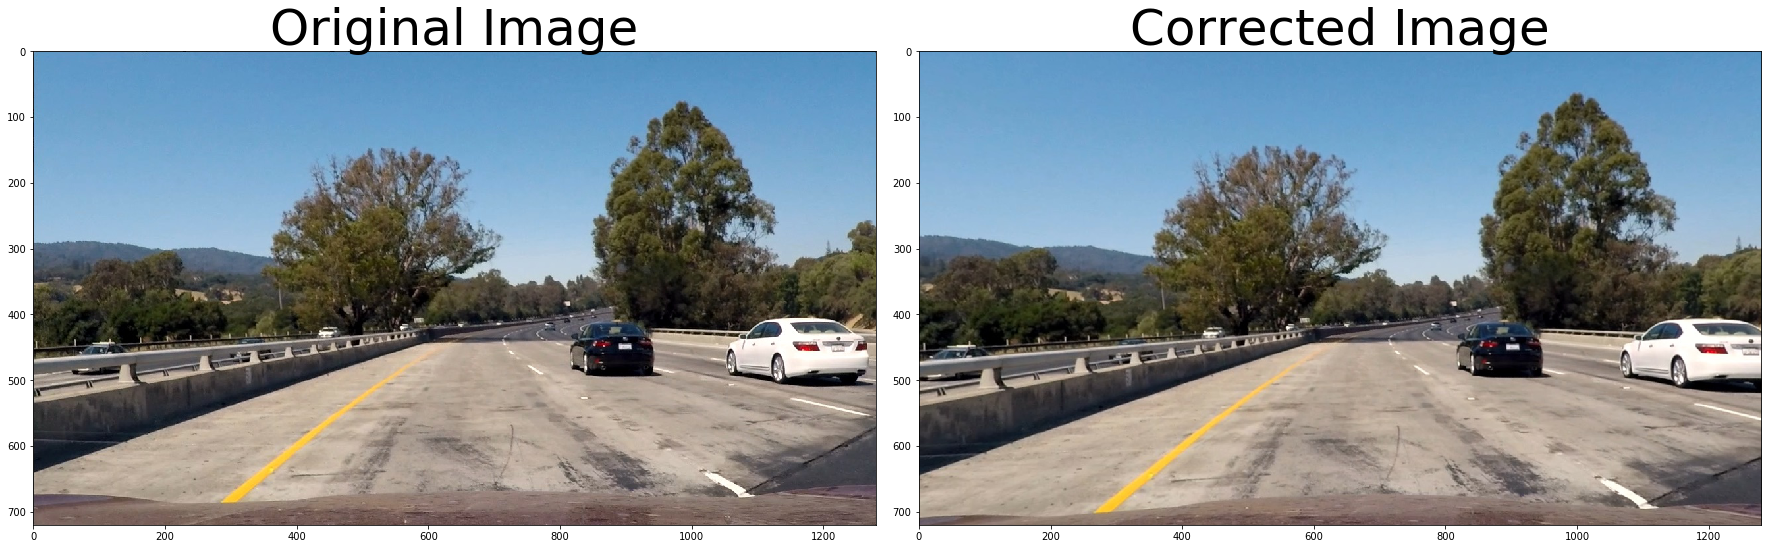

In [6]:
# Undistort road image
image = mpimg.imread('test_images/test1.jpg')

undist = cv2.undistort(image, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist)
ax2.set_title('Corrected Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.savefig('./output_images/undistort_road.jpg')

## Color transforms, gradients or other methods to create a thresholded binary image

In [7]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(gray, orient='x', thresh_min=0, thresh_max=255):
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def get_threshold(img):
    img = cv2.undistort(img, mtx,dist,None, mtx)
    
    # convert to gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    height, width = gray.shape
    
    # gradient threshold on x
    sx_binary = abs_sobel_thresh(gray,'x',10,200)
    
    # gradient direction threshold 
    direction_binary = dir_threshold(gray,thresh = (np.pi/6, np.pi/2))
    
    # combine 2 above binary
    sx_direction_binary = ((sx_binary==1) & (direction_binary==1))
    
    # R & G threshhold
    color_thresh = 160
    R = img[:,:,0]
    G = img[:,:,1]
    RG_binary = (R > color_thresh) & (G > color_thresh)
    
    # LHS threshold
    HLS = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = HLS[:,:,2]
    L = HLS[:,:,1]
    H = HLS[:,:,0]
    
    # S channel detect bright yellow and white lanes
    S_thresh = (90,255)
    S_binary = (S> S_thresh[0]) & (S <= S_thresh[1])
    
    # L channel threshhold to avoid shadow pixels
    L_thesh= (120,255)
    L_binary = (L > L_thesh[0]) & (L <= L_thesh[1])
    
    # Combine all thresholds
    combined_binary = np.zeros_like(R)
    combined_binary[(RG_binary & L_binary ) & (S_binary | sx_direction_binary )] = 1
    
    # apply to masked region
    mask = np.zeros_like(combined_binary)
    cropped_region = np.array([[0,height], [width/2, int(0.5*height)], \
                                            [width, height]], dtype=np.int32)
    cv2.fillPoly(mask, [cropped_region], 1)
    thresholded = cv2.bitwise_and(combined_binary, mask)
    
    return thresholded

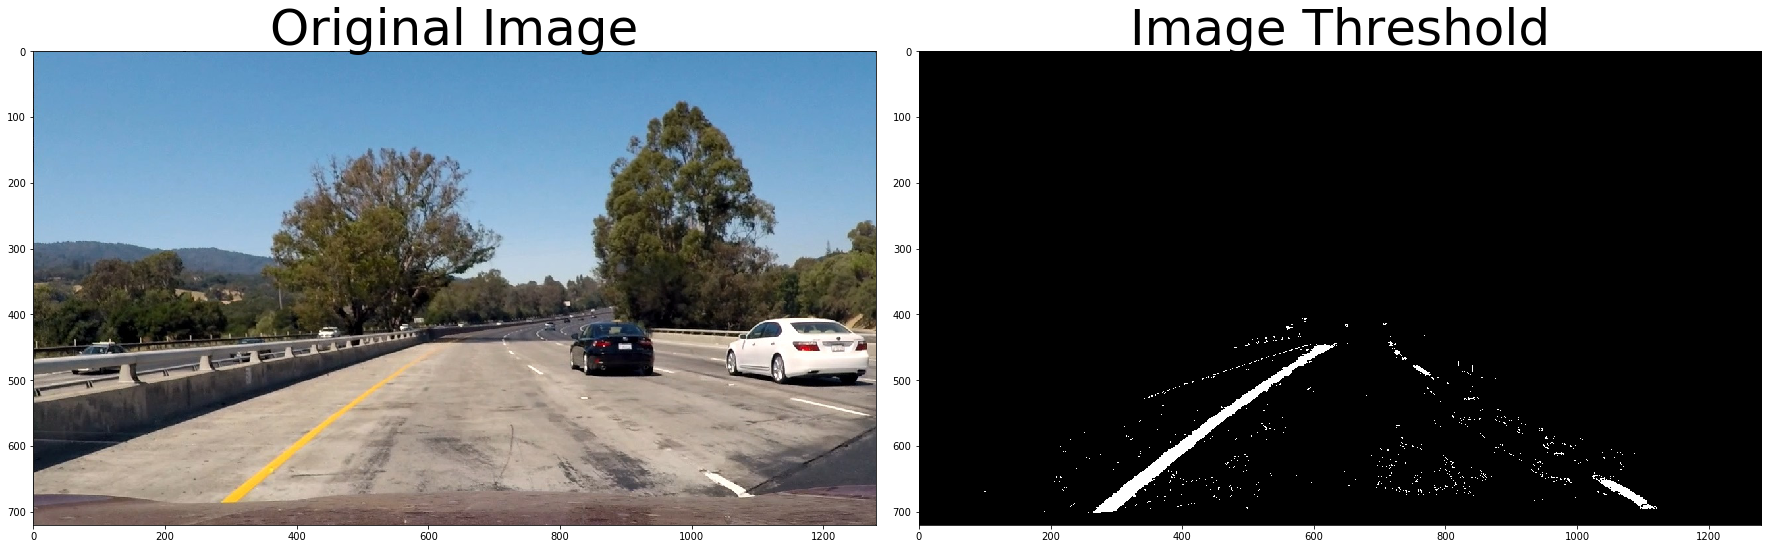

In [8]:
img = mpimg.imread('test_images/test1.jpg')
img_thresh = get_threshold (img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(img_thresh,cmap='gray')
ax2.set_title('Image Threshold', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.savefig('output_images/test1_threshold.jpg')

## Perspective Transform

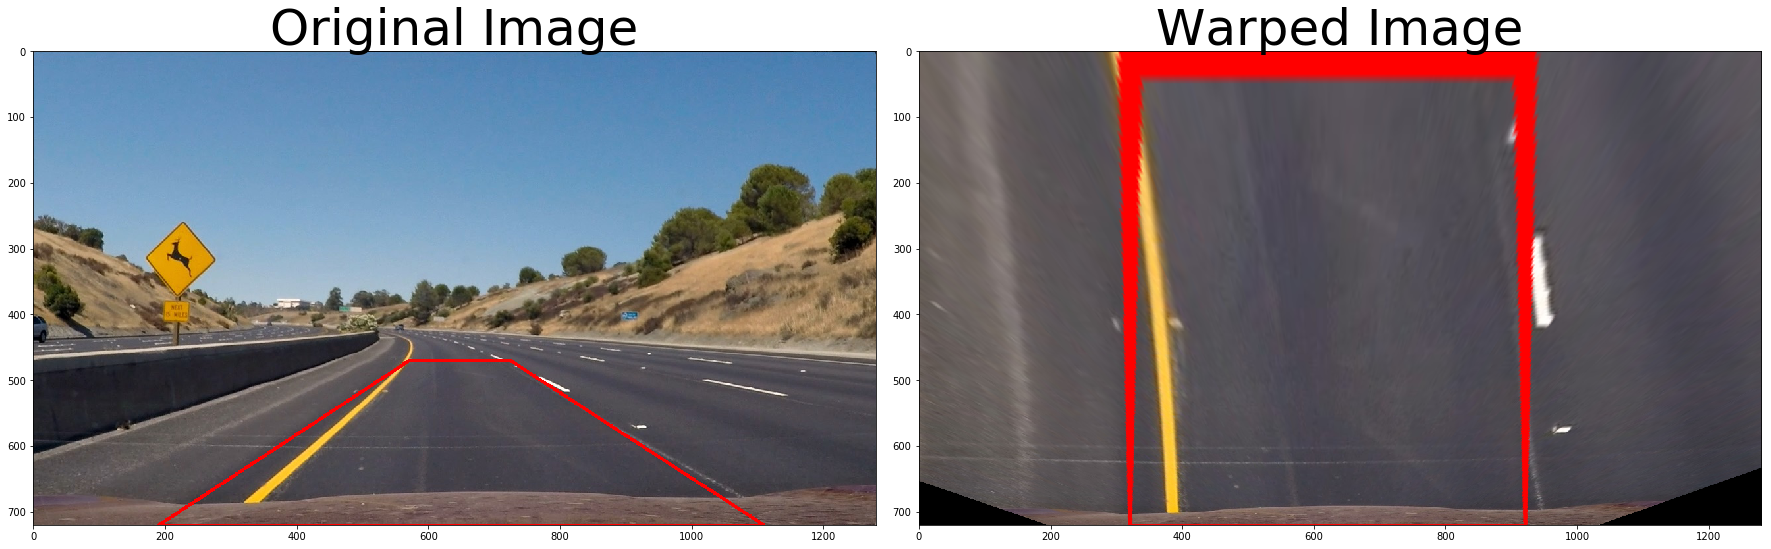

In [32]:
# Extract vertices
top_left = [570, 470]
top_right = [725, 470]
bottom_left = [190,720]
bottom_right = [1110, 720]

source = np.float32([bottom_left,bottom_right,top_right,top_left])

points = np.array([bottom_left,bottom_right,top_right,top_left], np.int32)
points = points.reshape((-1,1,2))
copy = img.copy()
cv2.polylines(copy,[points],True,(255,0,0), thickness=3)

# Destination points 
top_left = [320, 1]
top_right = [920, 1]
bottom_left = [320,720]
bottom_right = [920, 720]

dst = np.float32([bottom_left,bottom_right,top_right,top_left])
M = cv2.getPerspectiveTransform(source, dst)
Mint = cv2.getPerspectiveTransform(dst, source)
img_size = (img.shape[1], img.shape[0])

binary_warped = cv2.warpPerspective(img_thresh, M, img_size , flags=cv2.INTER_LINEAR)
warped_image = cv2.warpPerspective(copy, M, img_size , flags=cv2.INTER_LINEAR)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,9))
f.tight_layout()
ax1.imshow(copy)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped_image, cmap='gray')
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/perspective_transform.jpg')

## Identify lane-line pixels and fit their positions with a polynomial

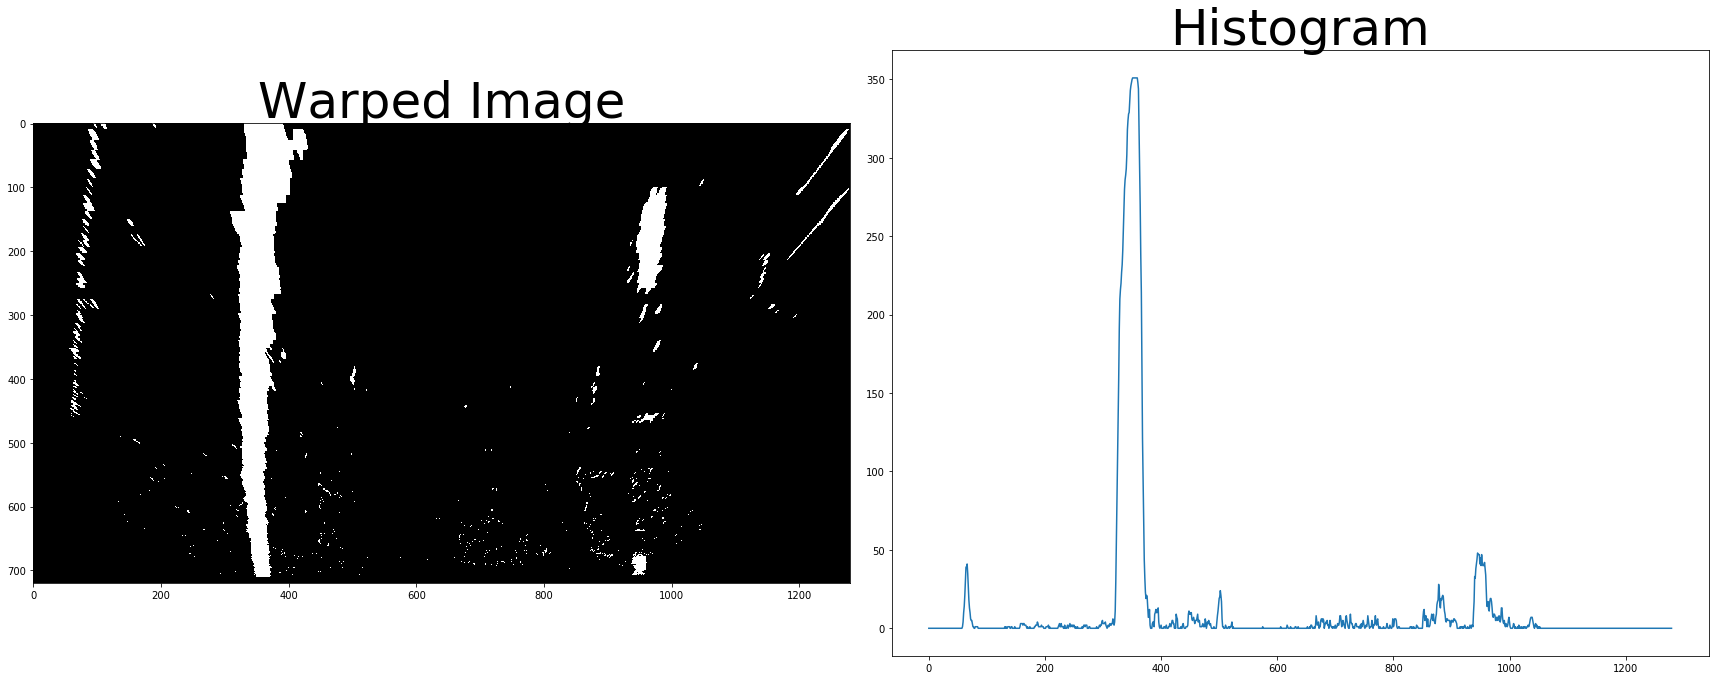

In [10]:
# Histogram of lane line
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

f, ax = plt.subplots(1, 2, figsize=(24,9))
f.tight_layout()

ax[0].imshow(binary_warped, cmap='gray')
ax[0].set_title('Warped Image', fontsize=50)

ax[1].plot(histogram)
ax[1].set_title('Histogram', fontsize=50)
plt.savefig('output_images/histogram.jpg')

In [11]:
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

# Current positions to be updated for each window
midpoint = np.int(histogram.shape[0]/2)
leftx_current = np.argmax(histogram[:midpoint])
rightx_current = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9

# Height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)

# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# Set the width of the windows +/- margin
margin = 100

# Set minimum number of pixels found to recenter window
minpix = 50

# Lists for left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)
    
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

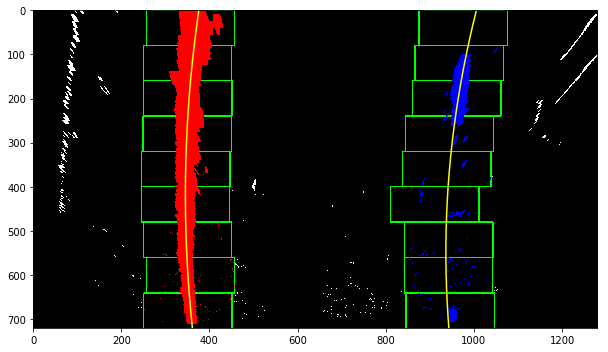

In [12]:
# Visualization
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

f,ax1 = plt.subplots(1, 1, figsize=(10,5))
f.tight_layout()
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, binary_warped.shape[1])
plt.ylim(binary_warped.shape[0], 0)
plt.savefig('output_images/test1_slidingWindow.jpg')

## Search Detected Lines

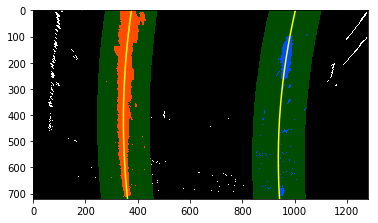

In [13]:
# Locate lines further
# Assume you have a new warped binary image
# Green Shade shows searched lines
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

margin = 100

left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin)))
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)

# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.savefig('output_images/test1_searchLane.jpg')

## Calculate the radius of curvature of the lane and the position of the vehicle with respect to center

In [14]:
def curvature_radius(x_values, warped):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    num_rows = warped.shape[0]
    y_pixels =  np.linspace(0, num_rows-1,num_rows)
    y_eval = np.max(y_pixels)
    
    # Fit new polynomials to x,y in world space
    fit_curve = np.polyfit(y_pixels *ym_per_pix, x_values*xm_per_pix, 2)
    curve_rad = ((1 + (2*fit_curve[0]*y_eval*ym_per_pix + fit_curve[1])**2)**1.5) / np.absolute(2*fit_curve[0])
    return curve_rad

def offset_from_center(left_fitx, right_fitx, pic_width):
    center_lane = (left_fitx[719] + right_fitx[719])/2.0
    xm_per_pix = 3.7/700
    center_pic = pic_width/2.0 
    center_offset_pixel  = abs(center_pic - center_lane)
    center_offset_meter = xm_per_pix * center_offset_pixel
    return center_offset_meter
    
left_curve_radius = curvature_radius(left_fitx, binary_warped)
right_curve_radius = curvature_radius(right_fitx, binary_warped)
average_curve_radius = (left_curve_radius + right_curve_radius)/ 2.0

# Calculate center offset
center_offset_meter = offset_from_center(left_fitx, right_fitx, pic_width= binary_warped.shape[0])

## Pipeline

In [25]:
def predicted_line (nonzerox, nonzeroy, left_lane_inds, right_lane_inds,num_rows):
    
    #Generate a prediction line for lane line by polynomial function based on non-zeros in sliding window
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]    
    # If no pixels were found return None
    if (lefty.size == 0 or leftx.size == 0):
        return None, None
    
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    if (rightx.size == 0 or righty.size == 0):
        return None, None
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, num_rows-1, num_rows )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]    
    return left_fitx,right_fitx

def line_search(binary_warped, margin=100, minpix=50):
    
    midpoint = np.int(histogram.shape[0]/2)
    leftx_current = np.argmax(histogram[:midpoint])
    rightx_current = np.argmax(histogram[midpoint:]) + midpoint

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    nwindows = 10
    nrows = binary_warped.shape[0]
    window_height = np.int(nrows/nwindows)
    
    # Current positions to be updated for each window
#     leftx_current = leftx_base
#     rightx_current = rightx_base
       
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Get predicted line
    left_predicted_x,right_predicted_x = predicted_line (nonzerox, nonzeroy, left_lane_inds, right_lane_inds,nrows)
    return left_predicted_x,right_predicted_x

def pipeline(img):
    # Global variables to store the polynomial
    global left_fit
    global right_fit
    
    img_shape = img.shape
    img_size = (img_shape[1], img_shape[0])
    
    # Image threshold
    thresholded_img = get_threshold(img)
    
    # Perspective transform
    warped = cv2.warpPerspective(thresholded_img, M, img_size, flags = cv2.INTER_LINEAR)
    
    # Sliding window
    out_img = np.dstack((warped, warped, warped))*255
    non_zeros = warped.nonzero()
    non_zeros_y = non_zeros[0]
    non_zeros_x = non_zeros[1]
    
    num_rows = warped.shape[0]
    ploty = np.linspace(0, num_rows-1, num_rows)
    
    # If polynomial coeff of the previous frame are none then perform re-search
    if (left_fit is None) or (right_fit is None): 
        first_search = True
        left_predicted_x, right_predicted_x = line_search(warped)
        
    # Else search in margin on each side of the previous polynomial fit
    else:
        first_search = False
        margin = 100
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        left_x_pixels = ((non_zeros_x >= left_fitx - margin) & \
                           (non_zeros_x <= left_fitx + margin)).nonzero()[0]
        right_x_pixels = ((non_zeros_x >= right_fitx - margin) & \
                            (non_zeros_x <= right_fitx + margin)).nonzero()[0]

        left_predicted_x, right_predicted_x = predicted_line(non_zeros_x, non_zeros_y, left_x_pixels,\
                                                                right_x_pixels,num_rows)

    if (left_predicted_x is None or right_predicted_x is None):
        if not first_search:
            left_predicted_x, right_predicted_x = line_searchfirst_search_for_line(warped)
            
    left_line_window = np.array(np.transpose(np.vstack([left_predicted_x, ploty])))
    right_line_window = np.array(np.flipud(np.transpose(np.vstack([right_predicted_x, ploty]))))
    
    # Compute curvature radius
    left_curve_radius = curvature_radius(left_predicted_x, warped)
    right_curve_radius = curvature_radius(right_predicted_x, warped)
    avg_curve_radius = (left_curve_radius + right_curve_radius)/2.0
    curve_radius_string = "Radius of curve = %.2f m" % avg_curve_radius
    
    # Compute the offset from center 
    center_offset = offset_from_center(left_predicted_x, right_predicted_x, img_size[0])
    center_offset_string = "Center offset = %.2f m" %center_offset
    
    # Reverse the perspective transform and fill predicted lane line
    poly_points = np.vstack([left_line_window, right_line_window])
    
    cv2.fillPoly(out_img, np.int_([poly_points]), [0,255, 0])
    
    unwarped = cv2.warpPerspective(out_img, Mint, img_size , flags=cv2.INTER_LINEAR)

    output = cv2.addWeighted(img, 1, unwarped, 0.3, 0)
    
    cv2.putText(output,curve_radius_string, (50, 70), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    cv2.putText(output,center_offset_string, (50, 140), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    
    return output

## Example image of your result plotted back down onto the road such that the lane area is identified clearly

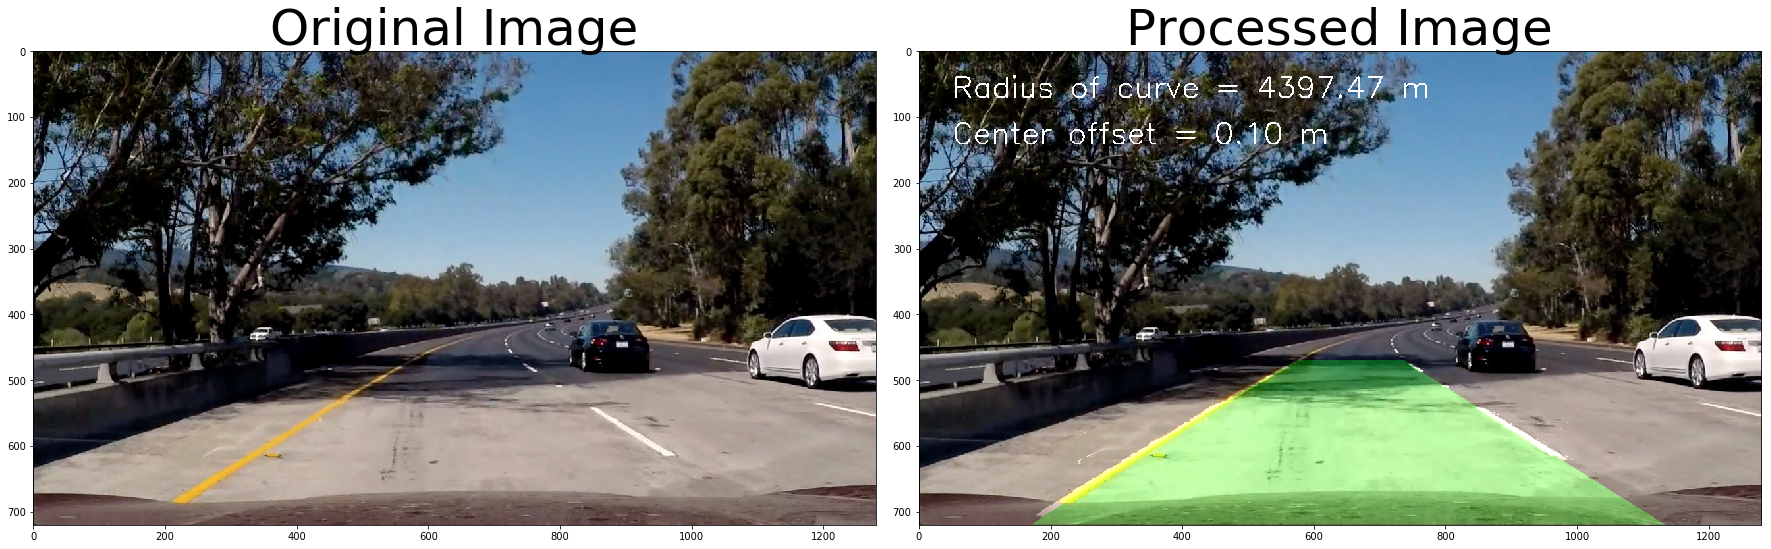

In [33]:
img = mpimg.imread('test_images/test5.jpg')

# left_fit = None
# right_fit = None

processed_img = pipeline(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(processed_img, cmap='gray')
ax2.set_title('Processed Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/test5_pipline.jpg')

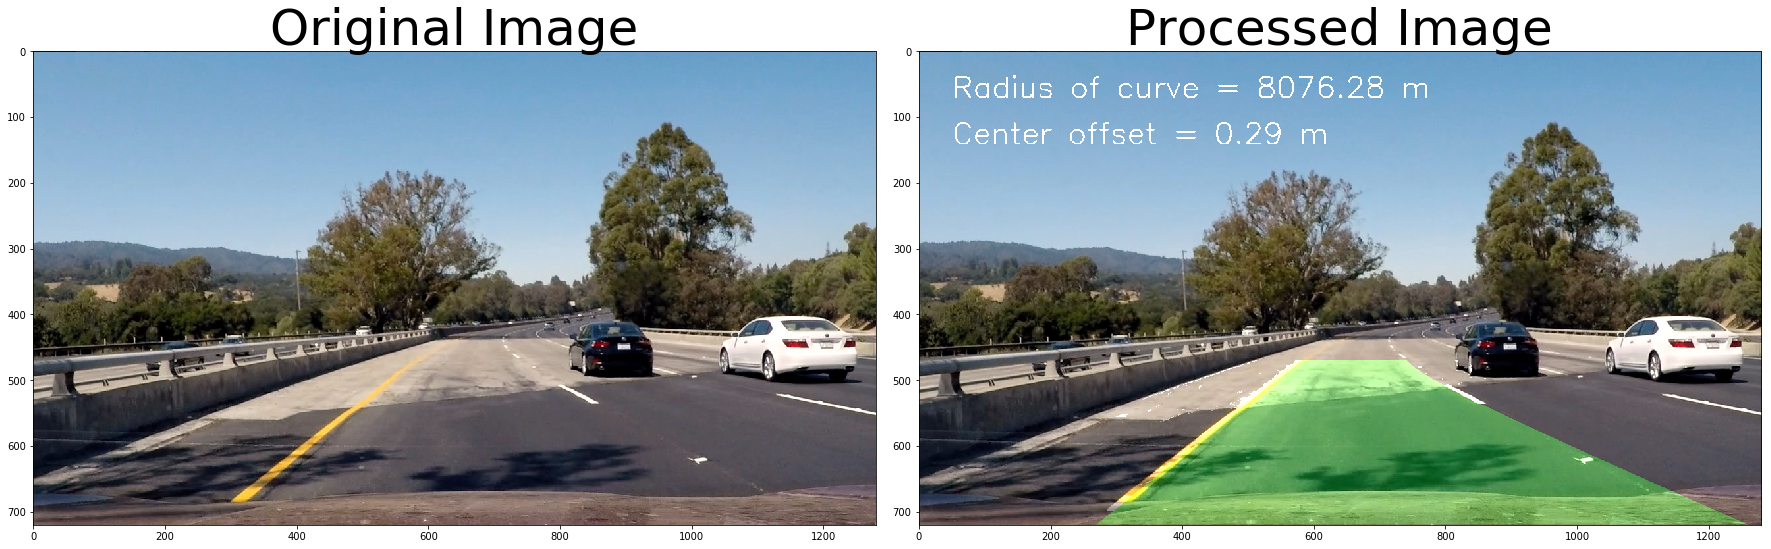

In [34]:
img = mpimg.imread('test_images/test4.jpg')

left_fit = None
right_fit = None

processed_img = pipeline(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(processed_img, cmap='gray')
ax2.set_title('Processed Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/test4_pipline.jpg')

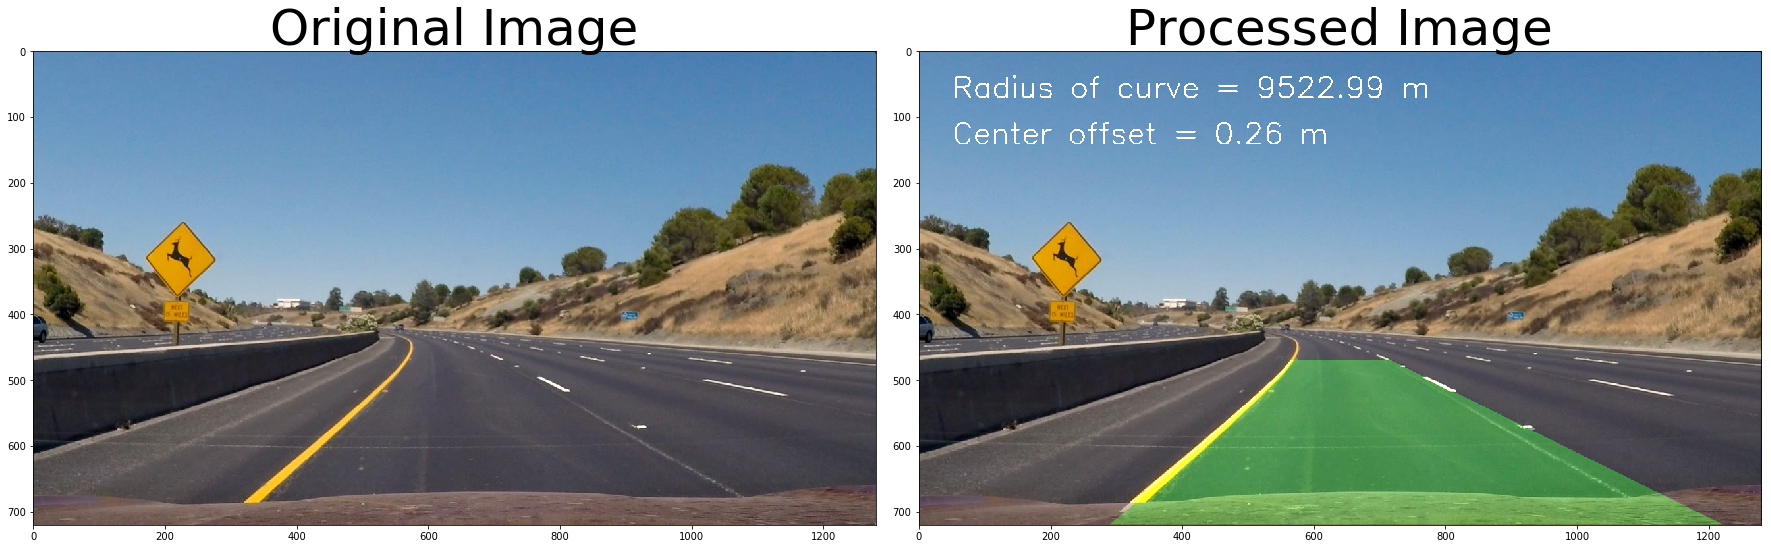

In [28]:
img = mpimg.imread('test_images/test2.jpg')

left_fit = None
right_fit = None

processed_img = pipeline(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(processed_img, cmap='gray')
ax2.set_title('Processed Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/test2_pipline.jpg')

In [232]:
left_fit = None
right_fit = None

input_video = VideoFileClip("project_video.mp4")
video_output = "project_video_result.mp4"
output = input_video.fl_image(pipeline)
%time output.write_videofile(video_output, audio = False)

[MoviePy] >>>> Building video project_video_result.mp4
[MoviePy] Writing video project_video_result.mp4


100%|█████████▉| 1260/1261 [03:45<00:00,  5.48it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_result.mp4 

CPU times: user 4min 1s, sys: 45.9 s, total: 4min 47s
Wall time: 3min 46s
